# Demonstration Bayesian Neural Networks for regression

In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import emcee
import corner

In [2]:
rng = np.random.default_rng(seed=2024)

## Generate data for regression problem

In [3]:
def DataGeneratingProcess(x, alpha=1., eps=0.1):
    dy = rng.normal(loc=0, scale=eps, size=x.shape)
    return np.exp(-alpha*x) + dy

In [4]:
alpha=1.
dy=0.05
xdata = np.sort(rng.uniform(size=10))
ydata = DataGeneratingProcess(xdata, alpha=alpha, eps=dy)

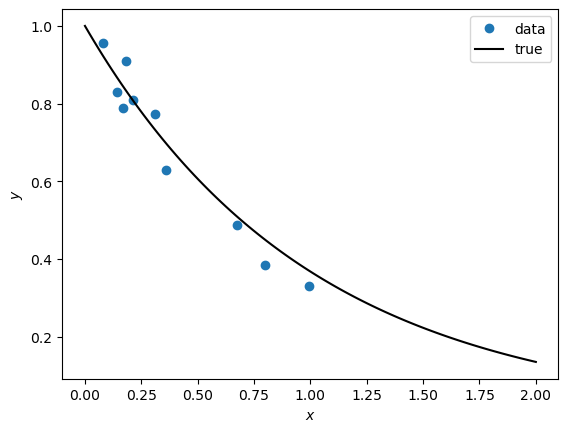

In [5]:
fig, ax =plt.subplots(1,1,)
ax.plot(xdata,ydata,'o', label='data')
xplot = np.linspace(0,2,100)
ytrue = DataGeneratingProcess(xplot, alpha=alpha, eps=0.)
ax.plot(xplot, ytrue,'k-',label='true')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc='best');

## First approach: FFNN for regression

In [6]:
import tensorflow as tf

In [7]:
# Construct three copies of a simple FFNN with one hidden layer
models={}
numModels = 3
for imodel in range(numModels):
    models[imodel] = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(10, activation='sigmoid',),
        tf.keras.layers.Dense(1, activation='linear',)
    ])
print(f'Initializing {numModels} identical FFNN models of the following architecture')
models[0].summary()

Initializing 3 identical FFNN models of the following architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
for imodel in range(numModels):
    models[imodel].compile(optimizer='adam',
                           loss='mean_squared_error')

In [9]:
history = {}
for imodel in range(numModels):
    print(f'Training model {imodel}')
    history[imodel] = models[imodel].fit(xdata, ydata, epochs=5000,verbose=0)

Training model 0
Training model 1
Training model 2


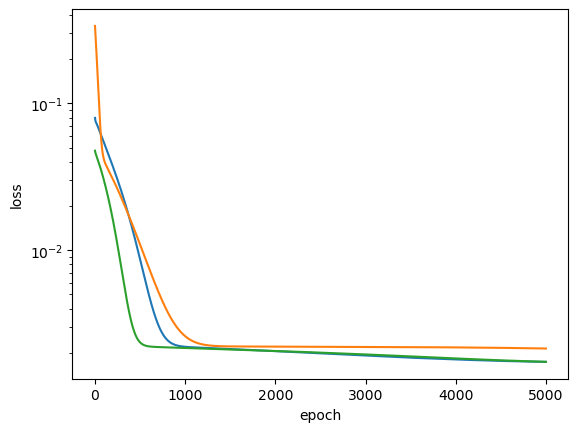

In [10]:
fig, ax = plt.subplots(1,1)
for imodel in range(numModels):
    ax.semilogy(history[imodel].history['loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss');

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x333b7e200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


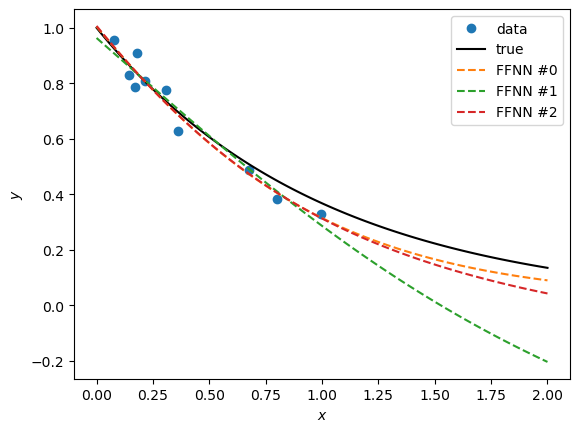

In [11]:
fig, ax =plt.subplots(1,1,)
ax.plot(xdata,ydata,'o', label='data')
xplot = np.linspace(0,2,100)
ytrue = DataGeneratingProcess(xplot, alpha=alpha, eps=0.)
ax.plot(xplot, ytrue,'k-',label='true')
for imodel in range(numModels):
    yFFNN = models[imodel].predict(xplot)
    ax.plot(xplot, yFFNN,'--',label=f'FFNN #{imodel}')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc='best');

Note the different predictions of the FFNN models. All have the same architecture, the same activation functions, and the same learning algorithms. However, initialization of weights is random and the gradient-based learning leads to different local minima.

How can we quantify the extrapolation error?

## Approach 2: A Bayesian Neural Network with MCMC sampling of weights

In [12]:
regWeight = 5.0

In [13]:
# First create a hard-coded FFNN as defined above
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def hardcodedFFNN(x, w):
    """
    Args:
        x: ndarray, len-Ndata
            array of inputs
        w: ndarray, shape=(31,)
            weights of the neural network
            w[0:9] = linear weights of the hidden layer
            w[10:19] = biases of the hidden layer
            w[20:29] = linear weights of the output layer
            w[30] = bias of the output layer

    Returns:
        ndarray, shape=(Ndata,1)
            array of outputs
    """
    Ndata = len(x)
    x = x.reshape(-1,1)
    # activations of the hidden layer
    z1 = w[10:20].reshape(1,-1) + np.dot(x, w[0:10].reshape(1,-1))
    # outputs of the hidden layer
    y1 = sigmoid(z1)
    # activations of the output layer
    zout = w[30] + np.dot(y1, w[20:30].reshape(-1,1))
    # linear output
    return zout

In [14]:
# test the functionality
# weights of tf models
weightsNN = {}
for imodel in range(numModels):
    weights = models[imodel].get_weights()
    # set a weight array with these weights
    weightsNN[imodel] = np.zeros(31)
    weightsNN[imodel][0:10] = weights[0].flatten()
    weightsNN[imodel][10:20] = weights[1].flatten()
    weightsNN[imodel][20:30] = weights[2].flatten()
    weightsNN[imodel][30] = weights[3].flatten()[0]
    # make predictions with tf model and hard-coded one
    modelPredict = models[imodel].predict(xplot)
    hardcodedFFNNPredict = hardcodedFFNN(xplot, weightsNN[imodel])
    if np.isclose(modelPredict,hardcodedFFNNPredict,atol=1e-7).all():
        print(f'The FFNN can reproduce the predictions of model {imodel}')
    else:
        print(f'The tf and hard-code model are different for model {imodel}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
The FFNN can reproduce the predictions of model 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
The FFNN can reproduce the predictions of model 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
The FFNN can reproduce the predictions of model 2


In [15]:
# Define the log prior, likelihood, posterior
#
def logLikelihood(w, xtrain, ytrain, dy=0.1):
    """
    Log likelihood for the FFNN model and normal errors
    
    Args:
        w: ndarray, len=31 
            array with the FFNN's biases and weights as defined above.
        xtrain: ndarray, shape (Ndata,1)
            array of input data
        ytrain: ndarray, shape (Ndata,1)
            array of output data
        dy: float (default 0.1)
            stddev of normal error
        
    Return
        log_likelihood 
    """
    residuals = hardcodedFFNN(xtrain,w) - ytrain.reshape(-1,1)
    return -0.5 * np.linalg.norm(residuals)**2 / dy**2.

def logPrior(w, dw=1.0):
    """
    Log prior for the parameters of a single neuron binary classifier
    
    Args:
        w: ndarray, len=31 
            array with the FFNN's biases and weights as defined above.
        dw: float (default=1.0)
            stddev of the Gaussian prior
        
    Return
        log_prior (gaussian) 
    """
    return - 0.5 * np.linalg.norm(w)**2 / dw**2

def logPosterior(w, xtrain, ytrain, dy=0.1, dw=1.0):
    return logPrior(w, dw=dw) + logLikelihood(w, xtrain, ytrain, dy=dy)

In [16]:
# Initialize the emcee sampler
ndim = 31  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
p0 = rng.normal(loc=0.0, scale=regWeight, size=(nwalkers, ndim))

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[xdata, ydata], kwargs={'dy': dy, 'dw': regWeight})

MCMC sampling using emcee (affine-invariant ensamble sampler) with 100 walkers


In [17]:
# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(p0, nburn,)
sampler.reset()

In [18]:
# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

Mean acceptance fraction: 0.012 (in total 1000000 steps)


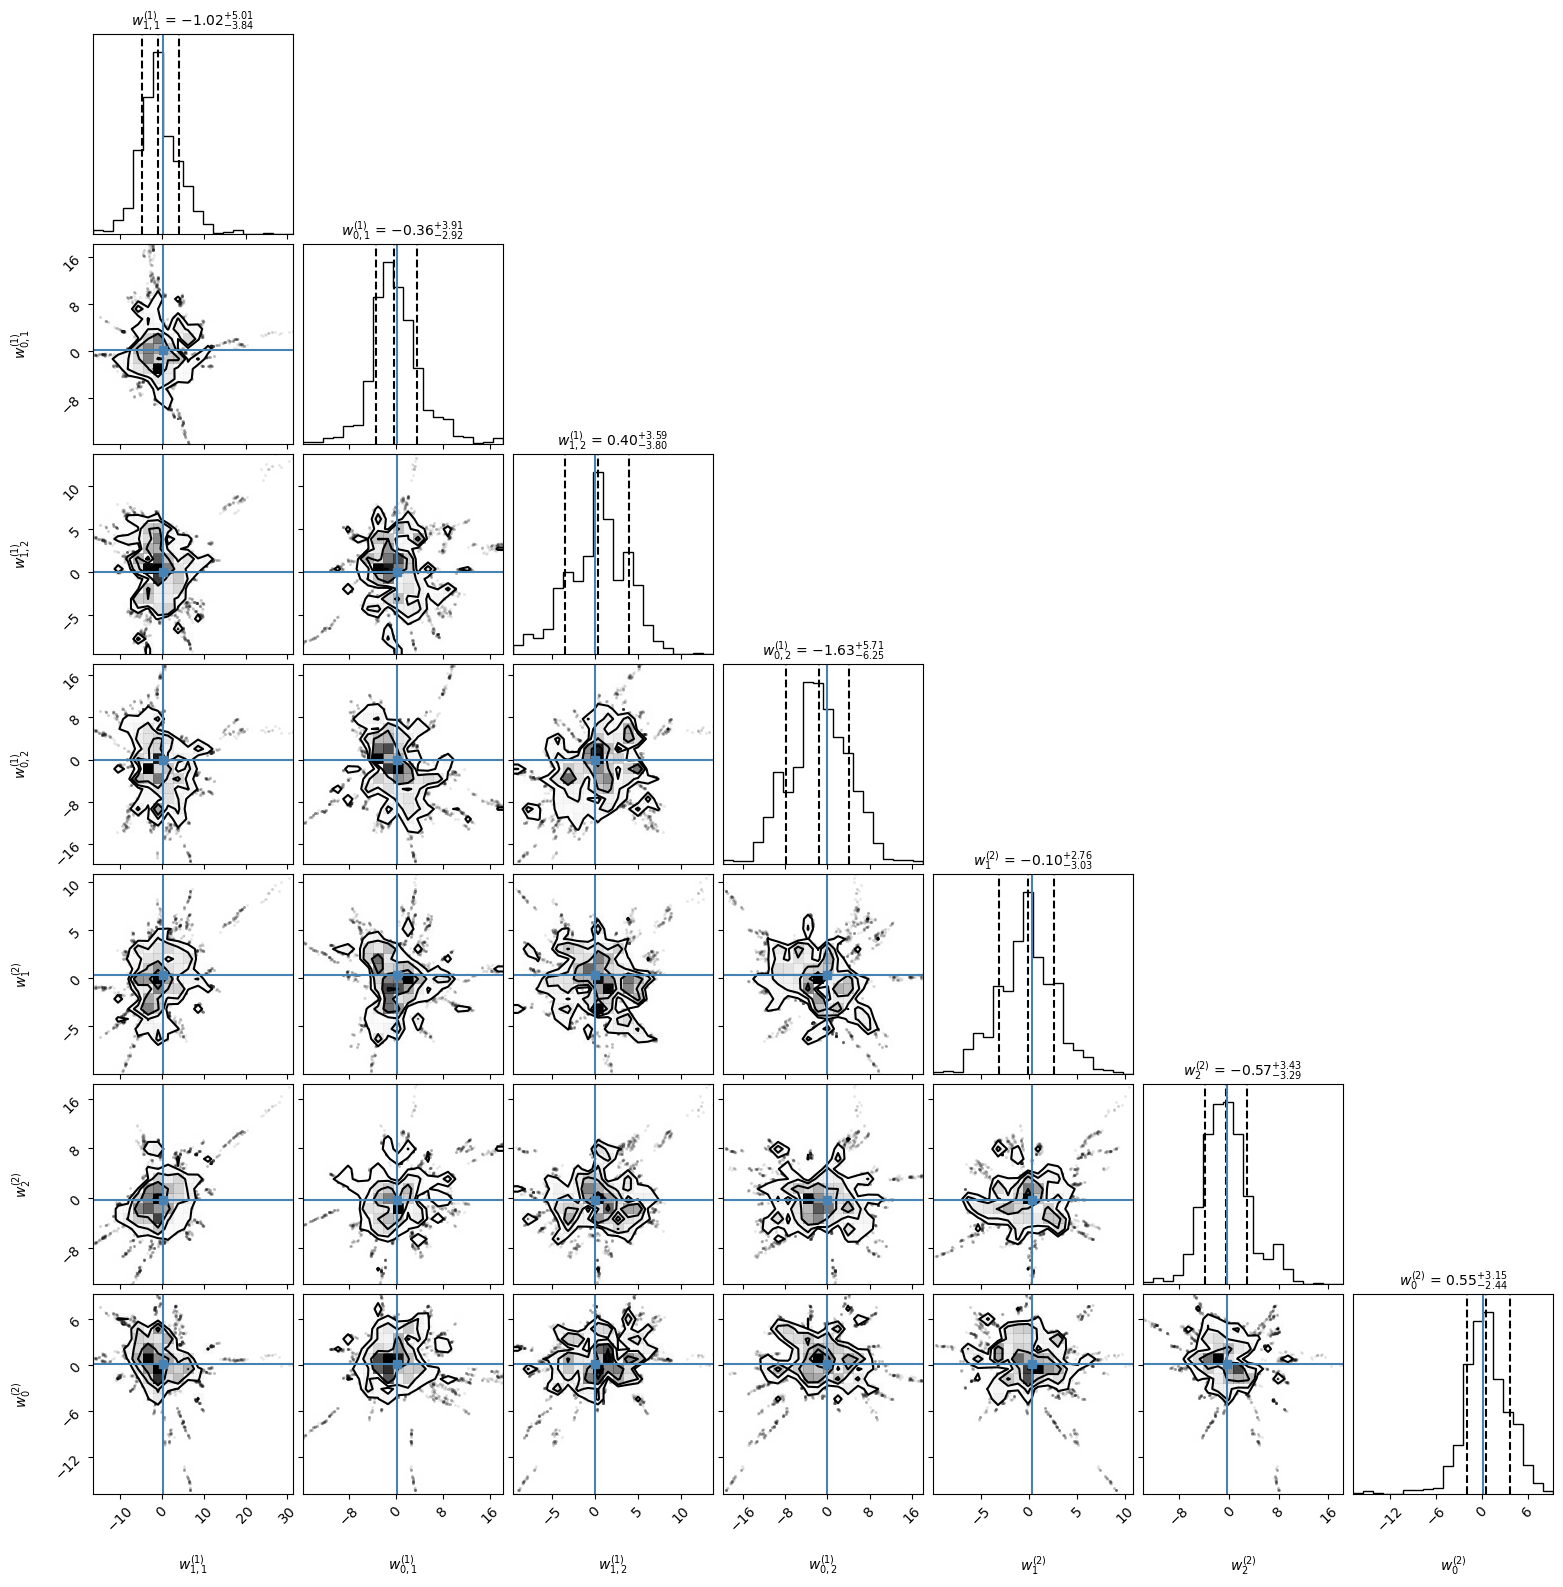

In [19]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples[::100,(0,10,1,11, 20, 21, 30)], labels=[r"$w^{(1)}_{1,1}$", r"$w^{(1)}_{0,1}$", \
                        r"$w^{(1)}_{1,2}$", r"$w^{(1)}_{0,2}$", r"$w^{(2)}_{1}$", r"$w^{(2)}_{2}$", r"$w^{(2)}_{0}$"],
                    truths=weightsNN[0][[0,10,1,11, 20, 21, 30]], quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 10})

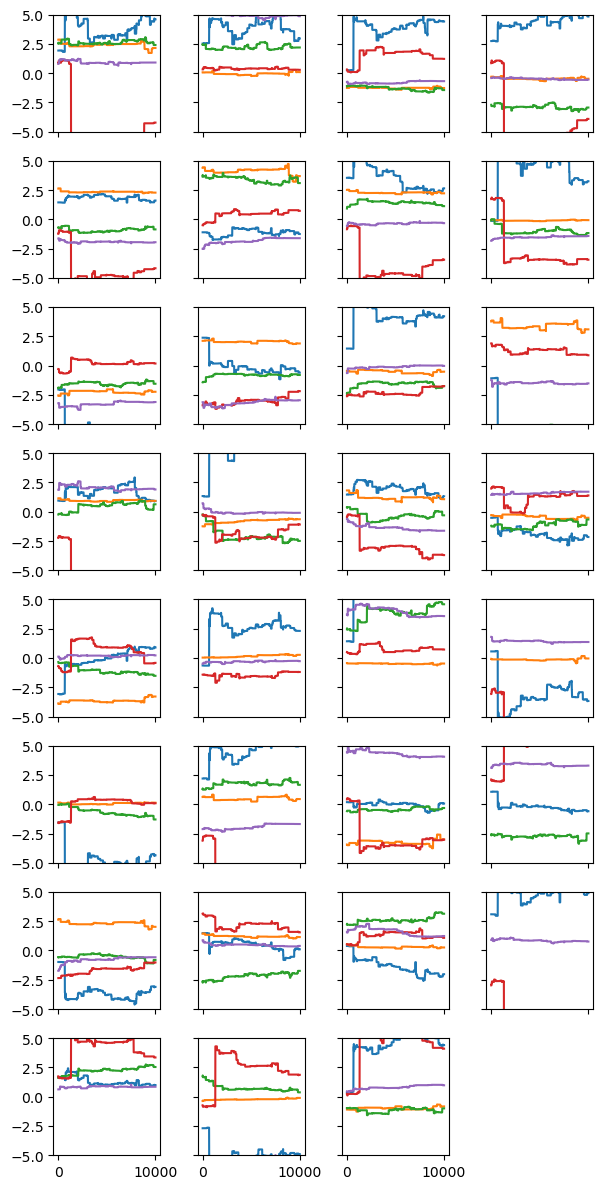

In [20]:
fig,axs = plt.subplots(8,4, sharey=True, sharex=True, figsize=(6,12))
histRange=(-regWeight,regWeight)

# Here we look at the traces for different walkers, but...
# ... NOTE that walkers are not independent in an ensamble sampler
for ipar in range(31):
    ax = axs.flatten()[ipar]
    for ichain in range(5):
        ax.plot(samples[ichain*nsteps:(ichain+1)*nsteps,ipar])
    ax.set_ylim(bottom=histRange[0], top=histRange[1])
axs.flatten()[-1].set_visible(False)
fig.tight_layout()

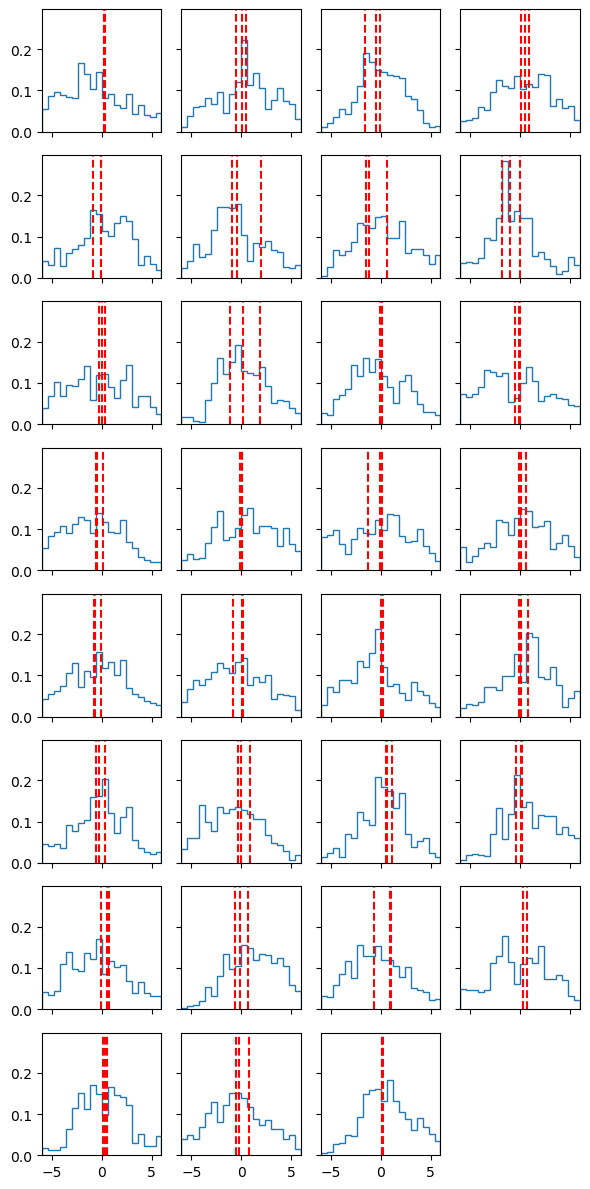

In [21]:
fig,axs = plt.subplots(8,4, sharey=True, sharex=True, figsize=(6,12))
histRange=(-6,6)

for ipar in range(31):
    ax = axs.flatten()[ipar]
    ax.hist(samples[:,ipar],density=True,histtype='step',range=histRange,bins=20)
    for imodel in range(numModels):
        ax.axvline(x=weightsNN[imodel][ipar],color='r',ls='--')
    ax.set_xlim(left=histRange[0], right=histRange[1])
axs.flatten()[-1].set_visible(False)
fig.tight_layout()

In [22]:
# For simplicity we will just take one PPD sample per walker
samplesPPD = np.zeros((nwalkers,len(xplot)))
for iwalker in range(nwalkers):
    samplePosterior = sampler.chain[iwalker,int(nsteps/2),:]
    samplesPPD[iwalker,:] = hardcodedFFNN(xplot, samplePosterior).flatten()
(PPDlo, PPDmed, PPDhi) = np.quantile(samplesPPD,(0.16, 0.5, 0.84),axis=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


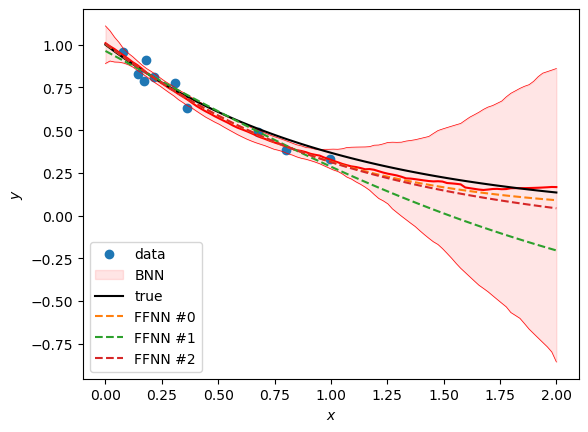

In [23]:
fig, ax =plt.subplots(1,1,)
ax.plot(xdata,ydata,'o', label='data')
ax.fill_between(xplot, PPDlo, PPDhi,color='r', alpha=0.1, label='BNN')
ax.plot(xplot, PPDmed, color='r')
ax.plot(xplot, PPDlo, color='r', lw=0.5)
ax.plot(xplot, PPDhi, color='r', lw=0.5)
xplot = np.linspace(0,2,100)
ytrue = DataGeneratingProcess(xplot, alpha=alpha, eps=0.)
ax.plot(xplot, ytrue,'k-',label='true')
for imodel in range(numModels):
    yFFNN = models[imodel].predict(xplot)
    ax.plot(xplot, yFFNN,'--',label=f'FFNN #{imodel}')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc='best');

## Approach 3: A Bayesian Neural Network with Variational Inference

In [24]:
import jax
import jax.numpy as jnp

In [25]:
# First create a hard-coded FFNN as defined above
# In order to employ the power of jax, we have to use jax.numpy
# for all numpy operations
def jsigmoid(z):
    return 1. / (1. + jnp.exp(-z))

def jhardcodedFFNN(x, w):
    """
    Args:
        x: ndarray, len-Ndata
            array of inputs
        w: ndarray, shape=(31,)
            weights of the neural network
            w[0:9] = linear weights of the hidden layer
            w[10:19] = biases of the hidden layer
            w[20:29] = linear weights of the output layer
            w[30] = bias of the output layer

    Returns:
        ndarray, shape=(Ndata,1)
            array of outputs
    """
    Ndata = len(x)
    x = x.reshape(-1,1)
    # activations of the hidden layer
    z1 = w[10:20].reshape(1,-1) + jnp.dot(x, w[0:10].reshape(1,-1))
    # outputs of the hidden layer
    y1 = jsigmoid(z1)
    # activations of the output layer
    zout = w[30] + jnp.dot(y1, w[20:30].reshape(-1,1))
    # linear output
    return zout

In [26]:
# jax.grad takes a function and returns a function
jax.grad(jsigmoid)(0.)

Array(0.25, dtype=float32, weak_type=True)

In [27]:
# test the functionality
# weights of tf models
weightsNN = {}
for imodel in range(numModels):
    weights = models[imodel].get_weights()
    # set a weight array with these weights
    weightsNN[imodel] = np.zeros(31)
    weightsNN[imodel][0:10] = weights[0].flatten()
    weightsNN[imodel][10:20] = weights[1].flatten()
    weightsNN[imodel][20:30] = weights[2].flatten()
    weightsNN[imodel][30] = weights[3].flatten()[0]
    # make predictions with tf model and hard-coded one
    modelPredict = models[imodel].predict(xplot)
    hardcodedFFNNPredict = jhardcodedFFNN(xplot, weightsNN[imodel])
    if np.isclose(modelPredict,hardcodedFFNNPredict,atol=1e-7).all():
        print(f'The jax FFNN can reproduce the predictions of model {imodel}')
    else:
        print(f'The tf and jax FFNN are different for model {imodel}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
The jax FFNN can reproduce the predictions of model 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
The jax FFNN can reproduce the predictions of model 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
The jax FFNN can reproduce the predictions of model 2


In [28]:
# Define the log prior, likelihood, posterior
#
def jlogLikelihood(w, xtrain, ytrain, dy=0.1):
    """
    Log likelihood for the FFNN model and normal errors
    
    Args:
        w: ndarray, len=31 
            array with the FFNN's biases and weights as defined above.
        xtrain: ndarray, shape (Ndata,1)
            array of input data
        ytrain: ndarray, shape (Ndata,1)
            array of output data
        dy: float (default 0.1)
            stddev of normal error
        
    Return
        log_likelihood 
    """
    residuals = jhardcodedFFNN(xtrain,w) - ytrain.reshape(-1,1)
    return -0.5 * jnp.linalg.norm(residuals)**2 / dy**2.

def jlogPrior(w, dw=1.0):
    """
    Log prior for the parameters of a single neuron binary classifier
    
    Args:
        w: ndarray, len=31 
            array with the FFNN's biases and weights as defined above.
        dw: float (default=1.0)
            stddev of the Gaussian prior
        
    Return
        log_prior (gaussian) 
    """
    return - 0.5 * jnp.linalg.norm(w)**2 / dw**2

def jlogPosterior(w, xtrain, ytrain, dy=0.1, dw=1.0):
    return jlogPrior(w, dw=dw) + jlogLikelihood(w, xtrain, ytrain, dy=dy)

In [29]:
# Time the original posterior
%timeit logPosterior(weightsNN[0],xdata, ydata, dy=dy, dw=regWeight)

7.92 µs ± 50.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [30]:
# Time the jax-evaluated posterior
%timeit jlogPosterior(weightsNN[0],xdata, ydata, dy=dy, dw=regWeight)

132 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
# The gradient with respect to the first argument
def gradLogPosterior(w):
    return jax.grad(jlogPosterior, argnums=0)(w,xdata, ydata, dy=dy, dw=regWeight)

In [32]:
# Evaluating the gradient comes at a computational cost
%timeit gradLogPosterior(weightsNN[0])

6.04 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In the following we use the Doubly Stochastical Variational Inference (DSVI) approach by Titsias and Lazaro-Gredilla (2014). Specifically, we implement their Algorithm 1 with
- $\Phi(\mathbf{z})$ is the standard normal distribution (independent components)
- $\mathbf{w} = \mathbf{C} \mathbf{z} + \boldsymbol{\mu}$
- We neglect correlations between weights by considering $\mathbf{C} = \text{diag}(\boldsymbol{\sigma})$
- Together with $\boldsymbol{\mu}$ we have $2 N_\mathrm{par}$ variational parameters.

The variational distribution 
$$
q\left( \boldsymbol{\theta} \vert \boldsymbol{\mu}, \mathbf{C}\right) = \frac{1}{|\mathbf{C}|} \Phi \left( \mathbf{C}^{-1}(\boldsymbol{\theta} - \boldsymbol{\mu}) \right),
$$
will be optimized to approximate the posterior $p(\boldsymbol{\theta} \vert \mathbf{y})$ via the KL divergence 
$$
D_\mathrm{KL} \left( q\left( \boldsymbol{\theta} \vert \boldsymbol{\mu}, \mathbf{C}\right) \, \vert\vert \, p(\boldsymbol{\theta} \vert \mathbf{y}) \right)
$$